<a href="https://colab.research.google.com/github/AldousSama/Tarea1/blob/main/Tarea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt  # Importamos matplotlib para la visualización (La uso para una prueba de validación de la red entrenada)
from mnist_loader import load_data_wrapper
from network import Network
import random
import numpy as np
# Carga los datos MNIST
training_data, validation_data, test_data = load_data_wrapper()

# Creamos una red neuronal con la arquitectura deseada (784 entradas, 30 neuronas en la capa oculta y 10 salidas)
net = Network([784, 30, 10])

# Entrenamos la red neuronal utilizando el Descenso de Gradiente Estocástico (SGD)
# Ajustamos los hiperparámetros según sea necesario (número de épocas, tamaño del mini lote, tasa de aprendizaje), apartir de aquí no hice muchas modificaciones en el codigo.
net.SGD(training_data, epochs=30, mini_batch_size=10, eta=3.0, test_data=test_data)
def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# network.py
"""
network.py
~~~~~~~~~~
IT WORKS

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]  #inicializa una red neuronal con capas de neuronas y establece los sesgos y las matrices de pesos para todas las conexiones entre las capas.
        # Inicializa variables RMSprop
        self.alpha = 0.001  # Tasa de aprendizaje
        self.beta = 0.9  # Factor de decaimiento para el promedio móvil ponderado
        self.epsilon = 1e-8  # Pequeño valor para evitar la división por cero
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.prev_square_gradients = [np.zeros(w.shape) for w in self.weights]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""  #calcula la salida de la red neuronal utilizando la propagación hacia adelante (feedforward). Cada capa aplica una transformación lineal
        for b, w in zip(self.biases, self.weights):                #(producto punto con pesos y suma de sesgos) seguida de una función de activación sigmoide para calcular las activaciones de las neuronas en esa capa.
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)        # se utiliza para preparar los datos de entrenamiento y prueba, convirtiéndolos en listas y calculando el número de ejemplos en cada conjunto.
        n = len(training_data)

        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        # Se crea una lista llamada loss_history para almacenar el valor de pérdida (costo) después de cada época (iteración completa de entrenamiento)
        loss_history = []

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

           # Calculamos y almacenamos la pérdida (costo) después de cada época
            if test_data:
                loss = self.calculate_loss(test_data)
                loss_history.append(loss)
                print("Epoch {} : {} / {} - Loss: {}".format(j, self.evaluate(test_data), n_test, loss))
            else:
                print("Epoch {} complete".format(j))

        # Serviria para graficar la historia de pérdidas
        if loss_history:
            plt.plot(range(epochs), loss_history)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss History')
            plt.show()

      # Inicializa variables RMSprop
        self.alpha = 0.001  # Tasa de aprendizaje
        self.beta = 0.9  # Factor de decaimiento para el promedio móvil ponderado
        self.epsilon = 1e-8  # Pequeño valor para evitar la división por cero
        self.prev_square_gradients = [np.zeros(w.shape) for w in self.weights]

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        for i in range(self.num_layers - 1):
            # Calcula el promedio móvil ponderado de los gradientes al cuadrado
            self.prev_square_gradients[i] = (self.beta * self.prev_square_gradients[i] +
                                          (1 - self.beta) * (nabla_w[i] ** 2))

           # Actualiza los pesos y sesgos utilizando RMSprop
            self.weights[i] -= (eta / np.sqrt(self.prev_square_gradients[i] + self.epsilon)) * nabla_w[i]
            self.biases[i] -= (eta / np.sqrt(self.prev_square_gradients[i] + self.epsilon)) * nabla_b[i]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def calculate_loss(self, test_data):
        """Calculate the loss (cost) on the test data."""
        loss = 0.0
        for x, y in test_data:
            a = self.feedforward(x)
            loss += np.linalg.norm(a - y)**2  # Mean squared error
        return loss / len(test_data)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Epoch 0 : 7361 / 10000
Epoch 1 : 8403 / 10000
Epoch 2 : 8402 / 10000
Epoch 3 : 9321 / 10000
Epoch 4 : 9398 / 10000
Epoch 5 : 9445 / 10000
Epoch 6 : 9437 / 10000
Epoch 7 : 9463 / 10000
Epoch 8 : 9457 / 10000
Epoch 9 : 9465 / 10000
Epoch 10 : 9502 / 10000
Epoch 11 : 9505 / 10000
Epoch 12 : 9494 / 10000
Epoch 13 : 9512 / 10000
Epoch 14 : 9520 / 10000
Epoch 15 : 9531 / 10000
Epoch 16 : 9504 / 10000
Epoch 17 : 9525 / 10000
Epoch 18 : 9506 / 10000
Epoch 19 : 9551 / 10000
Epoch 20 : 9486 / 10000
Epoch 21 : 9528 / 10000
Epoch 22 : 9518 / 10000
Epoch 23 : 9475 / 10000
Epoch 24 : 9526 / 10000
Epoch 25 : 9550 / 10000
Epoch 26 : 9506 / 10000
Epoch 27 : 9540 / 10000
Epoch 28 : 9554 / 10000
Epoch 29 : 9541 / 10000


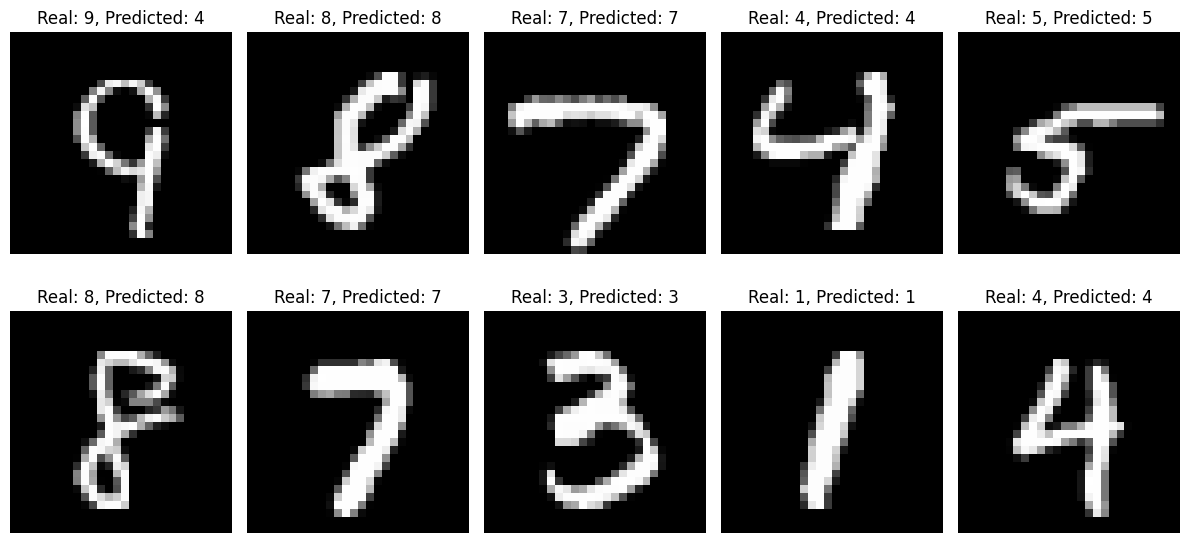

In [17]:

#Este codigo lo utilicé para visualizar un conjunto de muestras aleatorias (por eso el import random) del conjunto de datos de prueba juntos con las etiquetas relaes y las predicciones de la red
import random
sample_size = 10  # Define el tamaño de la muestra que deseas mostrar
training_data, validation_data, test_data = load_data_wrapper()
# Verificamos si test_data tiene suficientes elementos
test_data_list = list(test_data)
if len(test_data_list) < sample_size:
    print(f"No hay suficientes muestras en test_data. Disponible: {len(test_data_list)}, Solicitadas: {sample_size}")
else:
    # Seleccionamos un conjunto de muestras de test_data para visualizar
    sample_test_data = random.sample(test_data_list, sample_size)

    # Preparamos las etiquetas reales y las predicciones de la red
    real_labels = [int(y) for (_, y) in sample_test_data]
    predicted_labels = [np.argmax(net.feedforward(x)) for (x, _) in sample_test_data]

    # Visualizamos las imágenes junto con las etiquetas reales y las predicciones
    plt.figure(figsize=(12, 6))
    for i in range(sample_size):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.reshape(sample_test_data[i][0], (28, 28)), cmap='gray')
        plt.title(f'Real: {real_labels[i]}, Predicted: {predicted_labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()